## Import librairies

In [1]:
import pandas as pd
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Import data

In [2]:
df = pd.read_csv('pl_data.csv')

In [3]:
df

,images,category
0,Orange\Orange_177.jpg,Orange
1,Orange\Orange_318.jpg,Orange
2,Orange\Orange_473.jpg,Orange
3,Orange\Orange_202.jpg,Orange
4,Orange\Orange_412.jpg,Orange
...,...,...
1456,Bananes\Banana_262.jpg,Bananes
1457,Bananes\Banana_162.jpg,Bananes
1458,Orange\Orange_59.jpg,Orange
1459,Bananes\Banana_314.jpg,Bananes


In [4]:
df['category']

0        Orange
1        Orange
2        Orange
3        Orange
4        Orange
         ...   
1456    Bananes
1457    Bananes
1458     Orange
1459    Bananes
1460    Bananes
Name: category, Length: 1461, dtype: object

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['category'])
y = le.transform(df['category'])
print(y.shape)
print(list(le.inverse_transform([0, 1, 2])))

(1461,)
['Bananes', 'Orange', 'Pommes']


In [6]:
X = []
index = 0

for files in df.images: 
    X.append(cv2.cvtColor(cv2.imread(files), cv2.COLOR_BGR2RGB))
    index = index+1

X = np.asarray(X)
print(X.shape)

(1461, 100, 100, 3)


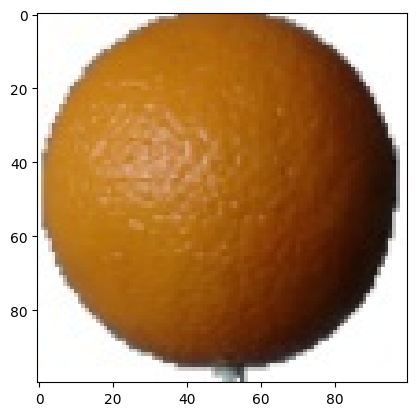

In [7]:
plt.imshow(X[0])

## Split into train and test

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(978, 100, 100, 3)
(978,)
(483, 100, 100, 3)
(483,)


In [9]:
# Create an image data generator with various augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation between -20 to +20 degrees
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    horizontal_flip=True,  # Random horizontal flips
    fill_mode='constant',  # Strategy for filling new pixels
    cval=255,  # Fill with white pixels
    brightness_range=[0.8, 1.2]  # Random brightness adjustment
)

# Fit the data generator on our training data
datagen.fit(X_train)

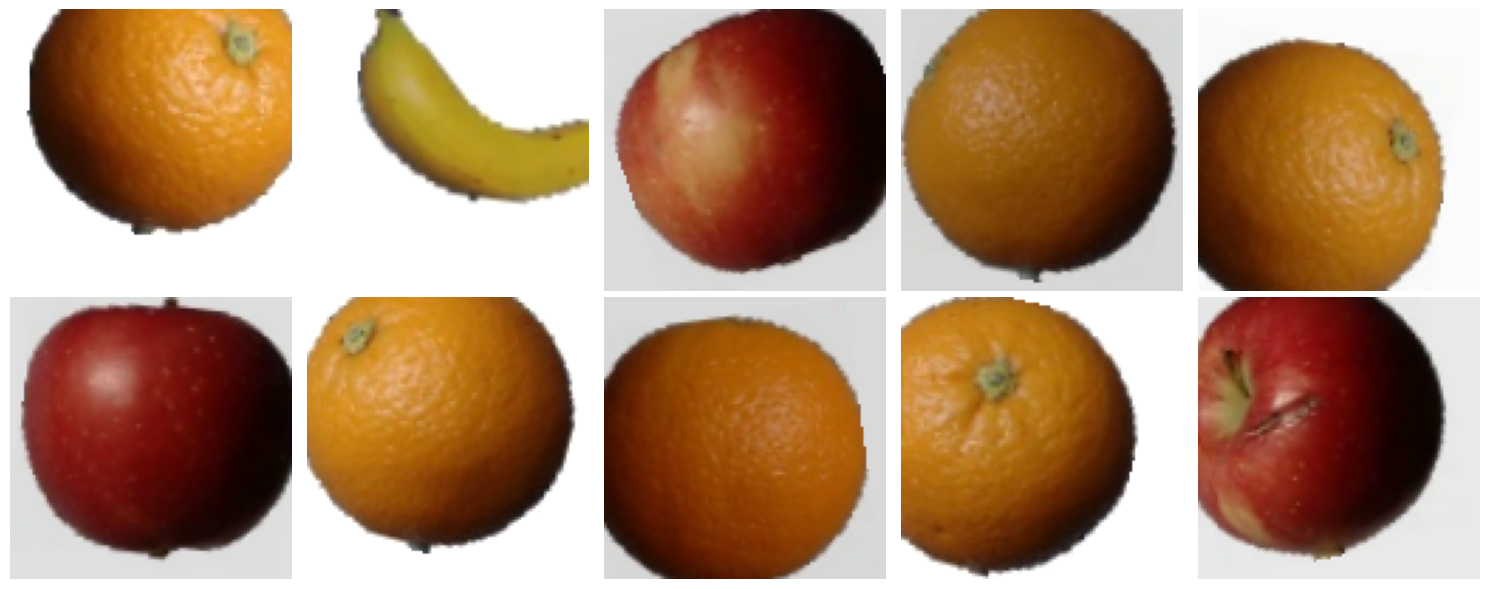

In [10]:
# Generate a batch of augmented images
augmented_images = next(datagen.flow(X_train, batch_size=10))

# Create a grid to display the images
fig, axes = plt.subplots(2, 5, figsize=(15, 6)) 
axes = axes.flatten()

# Display each image in the grid
for img, ax in zip(augmented_images, axes):
    ax.imshow(img.astype('uint8'))
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

## Build the model

In [11]:
model = keras.models.Sequential()

#model.add( keras.layers.Input((28,28,1))) #input layer

model.add( keras.layers.Conv2D(8, (3,3),  activation='relu', input_shape = (100,100,3)) )#8 2dconvolutiv planes, kernel size 3*3
model.add( keras.layers.MaxPooling2D((2,2)))#reduce the image size on 4
model.add( keras.layers.Dropout(0.2))#deactivate randomely some neuron outputs (regularization and avoid overfitting)

model.add( keras.layers.Conv2D(16, (3,3), activation='relu') )
model.add( keras.layers.MaxPooling2D((2,2)))
model.add( keras.layers.Dropout(0.2))

model.add( keras.layers.Conv2D(32, (3,3), activation='relu') )
model.add( keras.layers.MaxPooling2D((2,2)))
model.add( keras.layers.Dropout(0.3))

model.add( keras.layers.Flatten()) 
model.add( keras.layers.Dense(400, activation='relu'))
model.add( keras.layers.Dropout(0.1))
model.add( keras.layers.Dense(400, activation='relu'))
model.add( keras.layers.Dropout(0.2))

model.add( keras.layers.Dense(3, activation='softmax'))

c:\Users\sacha\OneDrive - Haute Ecole de Namur-Liege-Luxembourg\henallux 2024-2025\Q2\Systèmes intelligents\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

model.compile(optimizer='adam',#function for get down the gradient
              loss='sparse_categorical_crossentropy',#loss function for classification
              metrics=['accuracy']) #the metric 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 49, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 400)            │     1,280,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 400)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         1,203 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,448,035 (5.52 MB)

 Trainable params: 1,448,035 (5.52 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [13]:
%%time

batch_size  = 20
epochs      =  5
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size+1,
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=1
)

c:\Users\sacha\OneDrive - Haute Ecole de Namur-Liege-Luxembourg\henallux 2024-2025\Q2\Systèmes intelligents\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5594 - loss: 47.4264 - val_accuracy: 0.8799 - val_loss: 0.3015
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8897 - loss: 0.7406 - val_accuracy: 0.9938 - val_loss: 0.0356
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9592 - loss: 0.1451 - val_accuracy: 1.0000 - val_loss: 0.0193
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9667 - loss: 0.1666 - val_accuracy: 0.9917 - val_loss: 0.0294
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9752 - loss: 0.1339 - val_accuracy: 0.9917 - val_loss: 0.0190
CPU times: total: 5.12 s
Wall time: 9.81 s


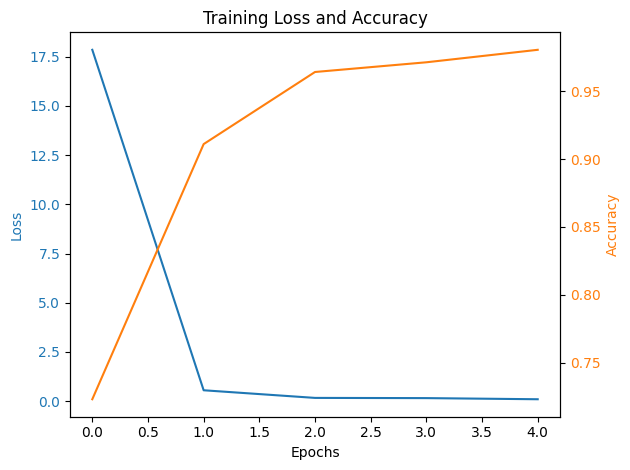

In [14]:
fig, ax1 = plt.subplots()

# Plot loss on the primary y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(history.history['loss'], label='Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:orange')
ax2.plot(history.history['accuracy'], label='Accuracy', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add a title and show the plot
plt.title('Training Loss and Accuracy')
fig.tight_layout()
plt.show()

## Evaluation

In [15]:
score = model.evaluate(X_test, y_test, verbose=0)

print(f'Test loss     : {score[0]:4.4f}')
print(f'Test accuracy : {score[1]:4.4f}')

Test loss     : 0.0190
Test accuracy : 0.9917


In [16]:
y_sigmoid = model.predict(X_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


              precision    recall  f1-score   support

           0     1.0000    0.9770    0.9884       174
           1     0.9714    1.0000    0.9855       136
           2     1.0000    1.0000    1.0000       173

    accuracy                         0.9917       483
   macro avg     0.9905    0.9923    0.9913       483
weighted avg     0.9920    0.9917    0.9917       483

0.9917184265010351


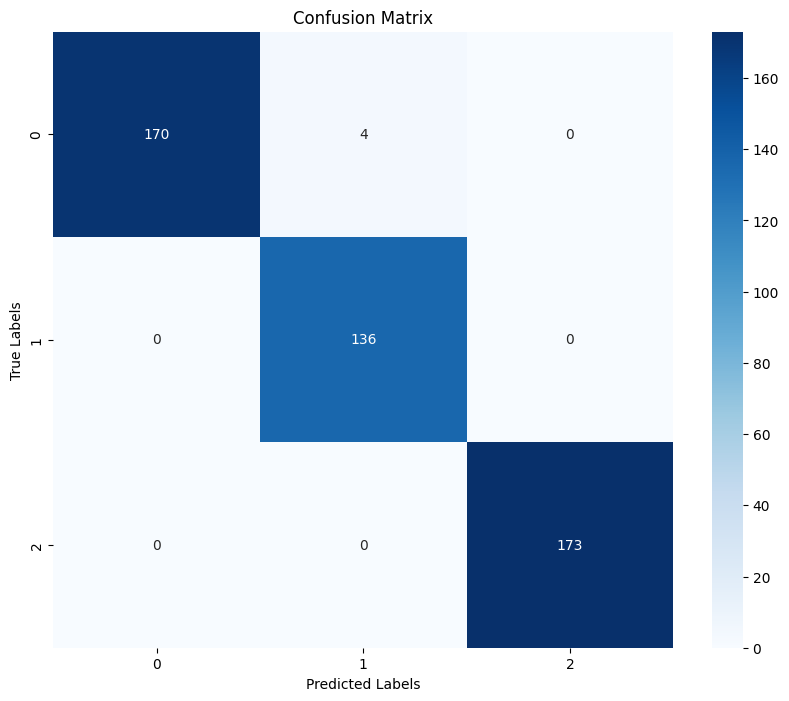

In [17]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
# import scikitplot as skplt 

print(classification_report(y_test,y_pred,digits = 4))
print(accuracy_score(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(3), yticklabels=range(3))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Save and load the model and try with new data

In [18]:
# YOU NEED TO CHANGE THE FILEPATH
model_path = "C:\\\\Users\\sacha\\OneDrive - Haute Ecole de Namur-Liege-Luxembourg\\henallux 2024-2025\\Q2\\Systèmes intelligents\\5. Reconnaissance de fruits\\reco.keras"
tf.keras.models.save_model(
    model,
    filepath = model_path,
    overwrite=True,
)

In [19]:

model2 = keras.models.load_model(model_path)

## Save the model bis

In [20]:
model_json = model.to_json()
with open("fruits_classifier.json", 'w') as json_file:
    json_file.write(model_json)
model.save("fruits_classifier.h5")

In [21]:
from keras.models import model_from_json
json_file = open("fruits_classifier.json", "r")
model_json = json_file.read()
json_file.close()
model2 = model_from_json(model_json)
model2.load_weights("fruits_classifier.h5")

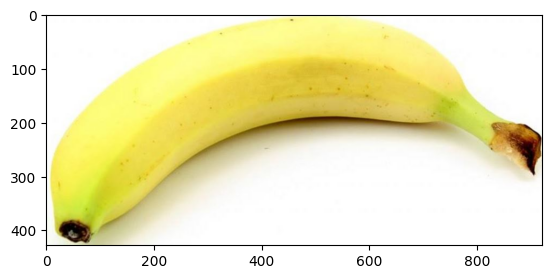

In [22]:
NewData1 = cv2.cvtColor(cv2.imread('NouvelleBanane.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(NewData1)

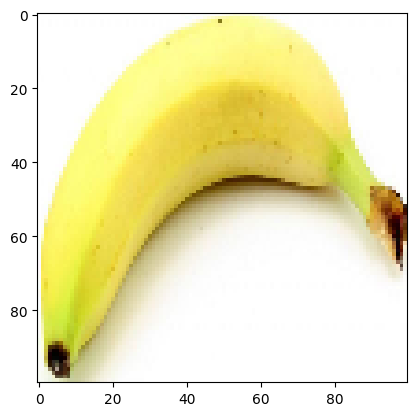

In [23]:
NewData1 = cv2.resize(NewData1,(100,100))
plt.imshow(NewData1)

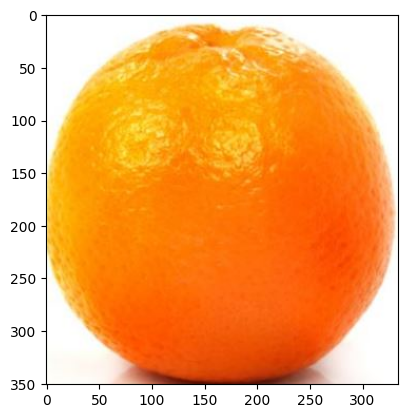

In [24]:
NewData2 = cv2.cvtColor(cv2.imread('NouvelleOrange.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(NewData2)

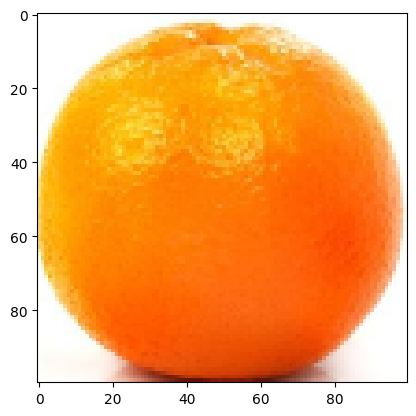

In [25]:
NewData2 = cv2.resize(NewData2,(100,100))
plt.imshow(NewData2)

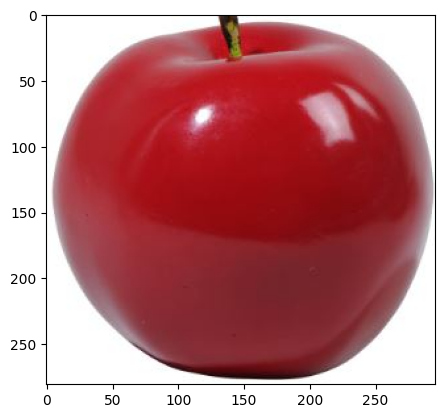

In [26]:
NewData3 = cv2.cvtColor(cv2.imread('NouvellePomme.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(NewData3)

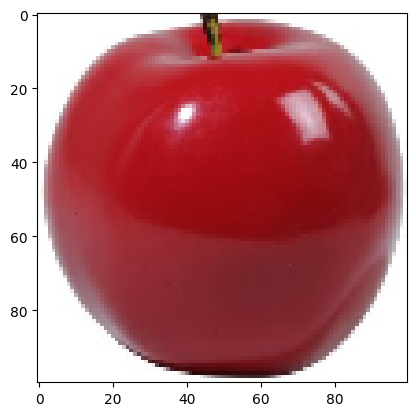

In [27]:
NewData3 = cv2.resize(NewData3,(100,100))
plt.imshow(NewData3)

In [28]:
NewData = np.stack((NewData1,NewData2,NewData3), axis = 0)

In [29]:
NewData.shape

(3, 100, 100, 3)

In [30]:
y_sigmoid = model2.predict(NewData)
y_pred    = np.argmax(y_sigmoid, axis=-1)
print(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[0 1 2]


# Next steps
adapt the code to classify the entire dataset available at https://github.com/Horea94/Fruit-Images-Dataset

Use the proposed train and test separation in the folders. 

first tackle only with the first word of each folder as class : "Apple Braeburn" -> "Apple" 
Then try to differentiate between the different categories of the same fruit.